Установка зависимостей (Colab)

In [1]:
!pip -q install -U pip
!pip -q install pandas numpy scikit-learn matplotlib joblib mlflow fastapi "uvicorn[standard]" pandera pytest requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00


Фикс путей + PYTHONPATH (Проблемы с Src..)

In [2]:
import os
import sys

PROJECT_DIR = "/content/credit-scoring-model"

os.makedirs(PROJECT_DIR, exist_ok=True)

# чтобы from src.... работало в ноутбуке
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

# удобнее работать из корня проекта
os.chdir(PROJECT_DIR)

print("cwd:", os.getcwd())
print("sys.path[0]:", sys.path[0])

cwd: /content/credit-scoring-model
sys.path[0]: /content/credit-scoring-model


Создаём структуру проекта

In [3]:
!mkdir -p /content/credit-scoring-model/{data/raw,data/processed,models,notebooks,tests,reports}
!mkdir -p /content/credit-scoring-model/src/{data,features,models,api}
!mkdir -p /content/credit-scoring-model/.github/workflows

!touch /content/credit-scoring-model/src/__init__.py
!touch /content/credit-scoring-model/src/data/__init__.py
!touch /content/credit-scoring-model/src/features/__init__.py
!touch /content/credit-scoring-model/src/models/__init__.py
!touch /content/credit-scoring-model/src/api/__init__.py

!ls -lah /content/credit-scoring-model | head -n 30

total 36K
drwxr-xr-x 9 root root 4.0K Jan 14 19:50 .
drwxr-xr-x 1 root root 4.0K Jan 14 19:50 ..
drwxr-xr-x 4 root root 4.0K Jan 14 19:50 data
drwxr-xr-x 3 root root 4.0K Jan 14 19:50 .github
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 models
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 notebooks
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 reports
drwxr-xr-x 6 root root 4.0K Jan 14 19:50 src
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 tests


датасет в data/raw

In [4]:
!cp -f /content/UCI_Credit_Card.csv /content/credit-scoring-model/data/raw/UCI_Credit_Card.csv
!ls -lah /content/credit-scoring-model/data/raw | head

total 2.8M
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 .
drwxr-xr-x 4 root root 4.0K Jan 14 19:50 ..
-rw-r--r-- 1 root root 2.8M Jan 14 19:50 UCI_Credit_Card.csv


requirements.txt

In [5]:
%%writefile /content/credit-scoring-model/requirements.txt
pandas
numpy
scikit-learn
matplotlib
joblib
mlflow
fastapi
uvicorn[standard]
pandera
pytest
requests

Writing /content/credit-scoring-model/requirements.txt


pytest.ini (опять для src)

In [6]:
%%writefile /content/credit-scoring-model/pytest.ini
[pytest]
pythonpath = .
testpaths = tests
addopts = -q

Writing /content/credit-scoring-model/pytest.ini


#IMPORTS

In [7]:
# стандартная библиотека
import os
import json
from typing import Dict, List, Tuple

# сторонние библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import joblib

import mlflow
import mlflow.sklearn

import pandera.pandas as pa
from pandera import Check, Column, DataFrameSchema

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import pytest
from google.colab import output



#Подготовка данных + Feature Engineering + Валидация

Валидация данных (Pandera)

In [8]:
%%writefile /content/credit-scoring-model/src/data/validation.py


Writing /content/credit-scoring-model/src/data/validation.py


In [9]:
#src/data/validation.py

TARGET_COL = "default.payment.next.month"


def build_schema() -> DataFrameSchema:
    # strict=False: в датасете много колонок, проверяем только ключевые
    schema = DataFrameSchema(
        {
            "LIMIT_BAL": Column(float, Check.ge(0), nullable=False, coerce=True),
            "AGE": Column(int, Check.in_range(18, 100), nullable=False, coerce=True),
            "SEX": Column(int, Check.isin([1, 2]), nullable=False, coerce=True),
            "EDUCATION": Column(int, Check.in_range(0, 6), nullable=False, coerce=True),
            "MARRIAGE": Column(int, Check.in_range(0, 3), nullable=False, coerce=True),
            TARGET_COL: Column(int, Check.isin([0, 1]), nullable=False, coerce=True),
        },
        strict=False,
        coerce=True,
    )
    return schema


def validate_df(df: pd.DataFrame) -> None:
    schema = build_schema()
    schema.validate(df)

Feature Engineering

In [10]:
%%writefile /content/credit-scoring-model/src/features/build_features.py


Writing /content/credit-scoring-model/src/features/build_features.py


In [11]:
#src/features/build_features.py

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 1) биннинг возраста — простая штука, но иногда помогает
    if "AGE" in df.columns:
        bins = [0, 24, 34, 44, 54, 64, 200]
        labels = ["<25", "25-34", "35-44", "45-54", "55-64", "65+"]
        df["AGE_BIN"] = pd.cut(df["AGE"], bins=bins, labels=labels, include_lowest=True)

    # 2) агрегаты по статусам PAY_0..PAY_6
    pay_cols = [c for c in df.columns if c.startswith("PAY_")]
    if len(pay_cols) > 0:
        df["PAY_STATUS_MEAN"] = df[pay_cols].mean(axis=1)

    # 3) суммы счетов и выплат
    bill_cols = [c for c in df.columns if c.startswith("BILL_AMT")]
    payamt_cols = [c for c in df.columns if c.startswith("PAY_AMT")]

    if len(bill_cols) > 0:
        df["BILL_TOTAL"] = df[bill_cols].sum(axis=1)

    if len(payamt_cols) > 0:
        df["PAY_TOTAL"] = df[payamt_cols].sum(axis=1)

    return df

Prepare

In [12]:
%%writefile /content/credit-scoring-model/src/data/make_dataset.py

Writing /content/credit-scoring-model/src/data/make_dataset.py


In [13]:

#src/data/make_dataset.py

RAW_PATH = "data/raw/UCI_Credit_Card.csv"
TRAIN_PATH = "data/processed/train.csv"
TEST_PATH = "data/processed/test.csv"


def main() -> None:
    if not os.path.exists(RAW_PATH):
        raise FileNotFoundError(f"Не найден файл: {RAW_PATH}")

    df = pd.read_csv(RAW_PATH)

    # маленькая очистка: иногда бывает ID колонка, уберём если есть
    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    # базовая проверка входных данных
    validate_df(df)

    # добавляем фичи
    df = add_features(df)

    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["default.payment.next.month"]
    )

    os.makedirs("data/processed", exist_ok=True)
    train_df.to_csv(TRAIN_PATH, index=False)
    test_df.to_csv(TEST_PATH, index=False)

    print(f"Saved: {TRAIN_PATH} {TEST_PATH}")
    print("Train shape:", train_df.shape, "Test shape:", test_df.shape)


if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


Saved: data/processed/train.csv data/processed/test.csv
Train shape: (24000, 28) Test shape: (6000, 28)


Запуск prepare-stage & проверка файлов

In [14]:
!cd /content/credit-scoring-model && python -m src.data.make_dataset
!ls -lah /content/credit-scoring-model/data/processed | head

total 4.4M
drwxr-xr-x 2 root root 4.0K Jan 14 19:50 .
drwxr-xr-x 4 root root 4.0K Jan 14 19:50 ..
-rw-r--r-- 1 root root 892K Jan 14 19:50 test.csv
-rw-r--r-- 1 root root 3.5M Jan 14 19:50 train.csv


#ЭТАП “EDA”

мини-EDA + сохранение графиков в reports/

Saved EDA figs to reports/: target_distribution.png, age_hist.png


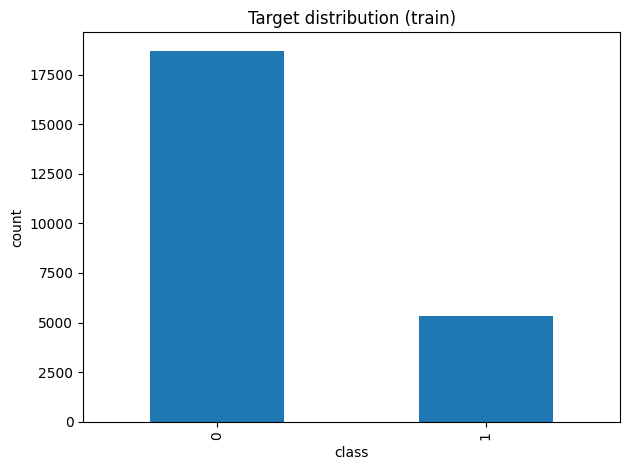

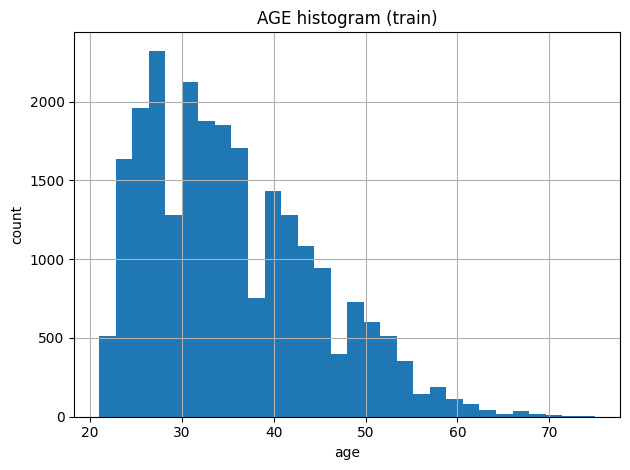

In [15]:

train_path = "/content/credit-scoring-model/data/processed/train.csv"
df = pd.read_csv(train_path)

# простенько посмотрим target
target = "default.payment.next.month"
counts = df[target].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Target distribution (train)")
plt.xlabel("class")
plt.ylabel("count")
plt.tight_layout()
plt.savefig("/content/credit-scoring-model/reports/target_distribution.png")

# небольшой sanity check по age
if "AGE" in df.columns:
    plt.figure()
    df["AGE"].hist(bins=30)
    plt.title("AGE histogram (train)")
    plt.xlabel("age")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig("/content/credit-scoring-model/reports/age_hist.png")

print("Saved EDA figs to reports/:",
      "target_distribution.png, age_hist.png")

#Pipeline & GridSearch & Метрики & ROC

Preprocessor

In [16]:
%%writefile /content/credit-scoring-model/src/models/pipeline.py

Writing /content/credit-scoring-model/src/models/pipeline.py


In [17]:
#src/models/pipeline.py

def make_preprocessor(
    numeric_features: List[str],
    categorical_features: List[str],
    dense_output: bool = False,
) -> ColumnTransformer:
    # numeric: медиана + масштабирование
    num_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    # categorical: most_frequent + onehot
    # Важно: HistGradientBoosting не любит sparse => можно принудить dense
    cat_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            (
                "onehot",
                OneHotEncoder(
                    handle_unknown="ignore",
                    sparse_output=(not dense_output),  # <- вот главный переключатель
                ),
            ),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_features),
            ("cat", cat_pipe, categorical_features),
        ]
    )
    return preprocessor

Train & MLflow & 5 экспериментов

In [18]:
%%writefile /content/credit-scoring-model/src/models/train.py


Writing /content/credit-scoring-model/src/models/train.py


2026/01/14 19:50:55 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 19:50:55 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 19:50:55 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 19:50:55 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/14 19:50:56 INFO alembic.runtime.migration: Running 

Best model: gboost Best ROC-AUC: 0.7789099657139872
Saved model: models/credit_default_model.pkl
Saved metrics: metrics.json


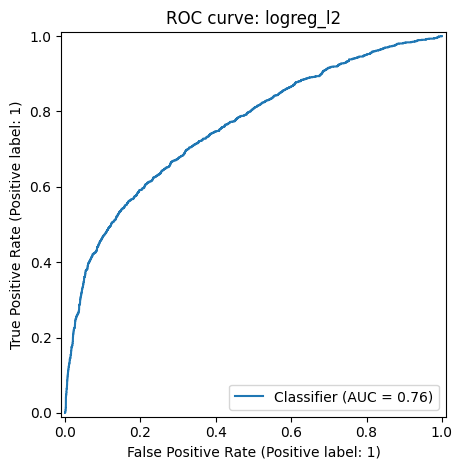

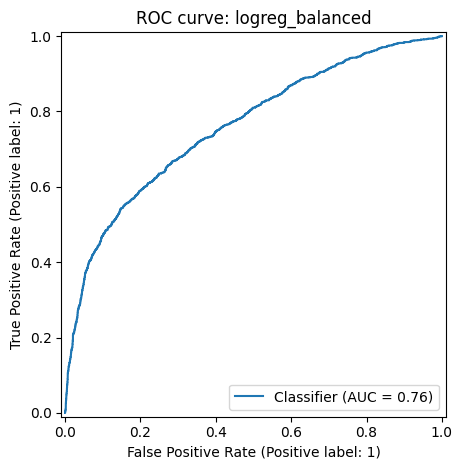

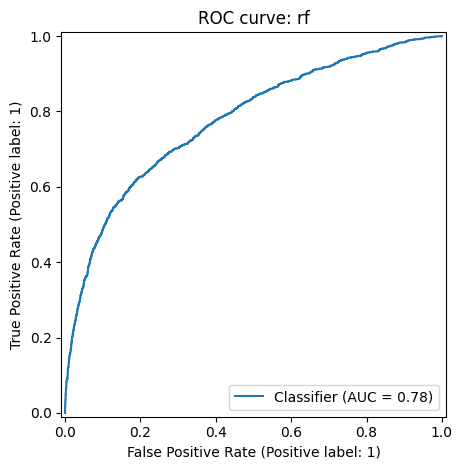

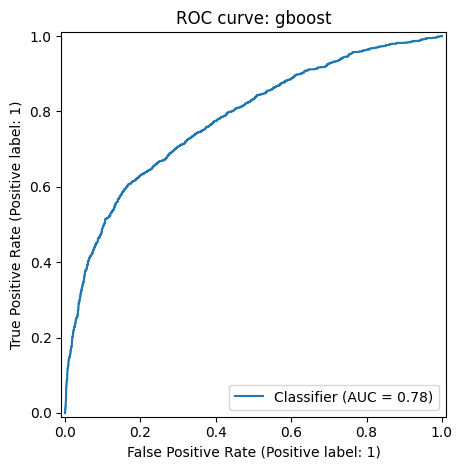

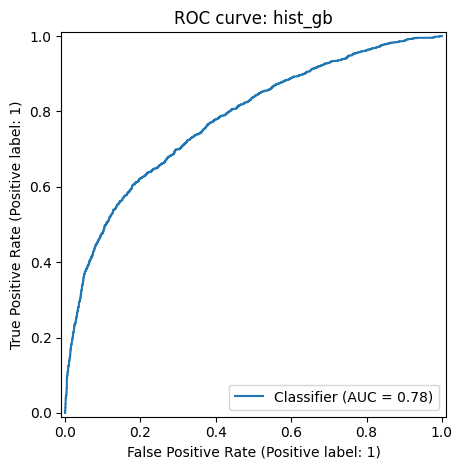

In [19]:
#src/models/train.py

TARGET_COL = "default.payment.next.month"
TRAIN_PATH = "data/processed/train.csv"
TEST_PATH = "data/processed/test.csv"


def _split_xy(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL])
    return X, y


def _calc_metrics(y_true, y_pred, y_proba) -> Dict[str, float]:
    return {
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }


def main() -> None:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    X_train, y_train = _split_xy(train_df)
    X_test, y_test = _split_xy(test_df)

    # типы признаков: немного вручную, но в учебке это норм
    numeric_features = [
        c for c in X_train.columns
        if c.startswith("BILL_AMT")
        or c.startswith("PAY_AMT")
        or c in ["LIMIT_BAL", "AGE", "PAY_STATUS_MEAN", "BILL_TOTAL", "PAY_TOTAL"]
    ]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    # 5 экспериментов (минимум по ТЗ)
    experiments = [
        (
            "logreg_l2",
            LogisticRegression(max_iter=200, solver="liblinear"),
            {"classifier__C": [0.2, 0.5, 1.0, 2.0]},
        ),
        (
            "logreg_balanced",
            LogisticRegression(max_iter=300, solver="liblinear", class_weight="balanced"),
            {"classifier__C": [0.2, 0.5, 1.0]},
        ),
        (
            "rf",
            RandomForestClassifier(random_state=42),
            {"classifier__n_estimators": [150, 200], "classifier__max_depth": [8, 10]},
        ),
        (
            "gboost",
            GradientBoostingClassifier(random_state=42),
            {"classifier__n_estimators": [80, 100], "classifier__learning_rate": [0.05, 0.1]},
        ),
        (
            "hist_gb",
            HistGradientBoostingClassifier(random_state=42),
            {"classifier__learning_rate": [0.05, 0.1], "classifier__max_depth": [None, 6]},
        ),
    ]

    # MLflow на sqlite (в Colab так удобнее всего)
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment("Credit_Default_Prediction")

    all_results = {}
    best_auc = -1.0
    best_model = None
    best_name = None

    for name, clf, grid in experiments:
        with mlflow.start_run(run_name=name):
            # hist_gb не умеет sparse -> принудительно делаем dense только для него
            dense_needed = (name == "hist_gb")
            preprocessor = make_preprocessor(
                numeric_features,
                categorical_features,
                dense_output=dense_needed,
            )

            pipe = Pipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("classifier", clf),
                ]
            )

            # маленький gridsearch, без фанатизма
            gs = GridSearchCV(pipe, grid, cv=3, scoring="roc_auc", n_jobs=-1)
            gs.fit(X_train, y_train)

            best_est = gs.best_estimator_
            y_proba = best_est.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= 0.5).astype(int)

            metrics = _calc_metrics(y_test, y_pred, y_proba)

            # логируем в MLflow
            mlflow.log_param("model_name", name)
            mlflow.log_params(gs.best_params_)
            mlflow.log_metric("cv_best_roc_auc", float(gs.best_score_))
            mlflow.log_metric("test_roc_auc", metrics["roc_auc"])
            mlflow.log_metric("test_precision", metrics["precision"])
            mlflow.log_metric("test_recall", metrics["recall"])
            mlflow.log_metric("test_f1", metrics["f1"])

            # ROC-кривая как артефакт
            os.makedirs("reports", exist_ok=True)
            fig = plt.figure()
            RocCurveDisplay.from_predictions(y_test, y_proba)
            plt.title(f"ROC curve: {name}")
            plt.tight_layout()

            roc_path = f"reports/roc_{name}.png"
            plt.savefig(roc_path)
            plt.close(fig)

            mlflow.log_artifact(roc_path)

            # модель как артефакт
            mlflow.sklearn.log_model(best_est, "model")

            all_results[name] = {**metrics, "best_params": gs.best_params_}

            if metrics["roc_auc"] > best_auc:
                best_auc = metrics["roc_auc"]
                best_model = best_est
                best_name = name

    # сохраняем лучшую модель и метрики (для DVC/Docker/FastAPI)
    os.makedirs("models", exist_ok=True)
    model_path = "models/credit_default_model.pkl"
    joblib.dump(best_model, model_path)

    with open("metrics.json", "w", encoding="utf-8") as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)

    print("Best model:", best_name, "Best ROC-AUC:", best_auc)
    print("Saved model:", model_path)
    print("Saved metrics: metrics.json")


if __name__ == "__main__":
    main()

Запуск train-stage & проверка результатов (>10 min run)

In [20]:
!cd /content/credit-scoring-model && python -m src.models.train
!ls -lah /content/credit-scoring-model | grep -E "mlflow.db|mlruns|metrics.json" || true
!ls -lah /content/credit-scoring-model/models | head
!cat /content/credit-scoring-model/metrics.json | head -n 60

-rw-r--r--  1 root root 1.2K Jan 14 19:54 metrics.json
-rw-r--r--  1 root root 528K Jan 14 19:54 mlflow.db
drwxr-xr-x  3 root root 4.0K Jan 14 19:51 mlruns
total 128K
drwxr-xr-x  2 root root 4.0K Jan 14 19:54 .
drwxr-xr-x 10 root root 4.0K Jan 14 19:54 ..
-rw-r--r--  1 root root 120K Jan 14 19:54 credit_default_model.pkl
{
  "logreg_l2": {
    "roc_auc": 0.7591859535231897,
    "precision": 0.6661971830985915,
    "recall": 0.35644310474755087,
    "f1": 0.4644084437898871,
    "best_params": {
      "classifier__C": 0.2
    }
  },
  "logreg_balanced": {
    "roc_auc": 0.759304158910614,
    "precision": 0.490352628077179,
    "recall": 0.5553880934438583,
    "f1": 0.5208480565371024,
    "best_params": {
      "classifier__C": 0.2
    }
  },
  "rf": {
    "roc_auc": 0.7764208795545158,
    "precision": 0.6671709531013615,
    "recall": 0.33232856066315,
    "f1": 0.44366197183098594,
    "best_params": {
      "classifier__max_depth": 10,
      "classifier__n_estimators": 200
    }
 

MLflow UI

In [21]:
url = output.eval_js("google.colab.kernel.proxyPort(5000)")
print("MLflow URL:", url)

MLflow URL: https://5000-m-s-1661x5hti63fu-a.us-central1-1.prod.colab.dev


In [22]:
!cd /content/credit-scoring-model && mlflow ui \
  --backend-store-uri sqlite:///mlflow.db \
  --host 0.0.0.0 \
  --port 5000 \
  --allowed-hosts '*' \
  --cors-allowed-origins '*'

Registry store URI not provided. Using backend store URI.
2026/01/14 19:54:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 19:54:53 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 19:54:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 19:54:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 19:54:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 19:54:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 19:54:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 19:54:53 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 19:54:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 19:54:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.
[MLflow] Security middleware enabled. Allowed hosts: *. CORS origins: *.
INFO:     Uvicorn running on http://0.0.0.0:5000 

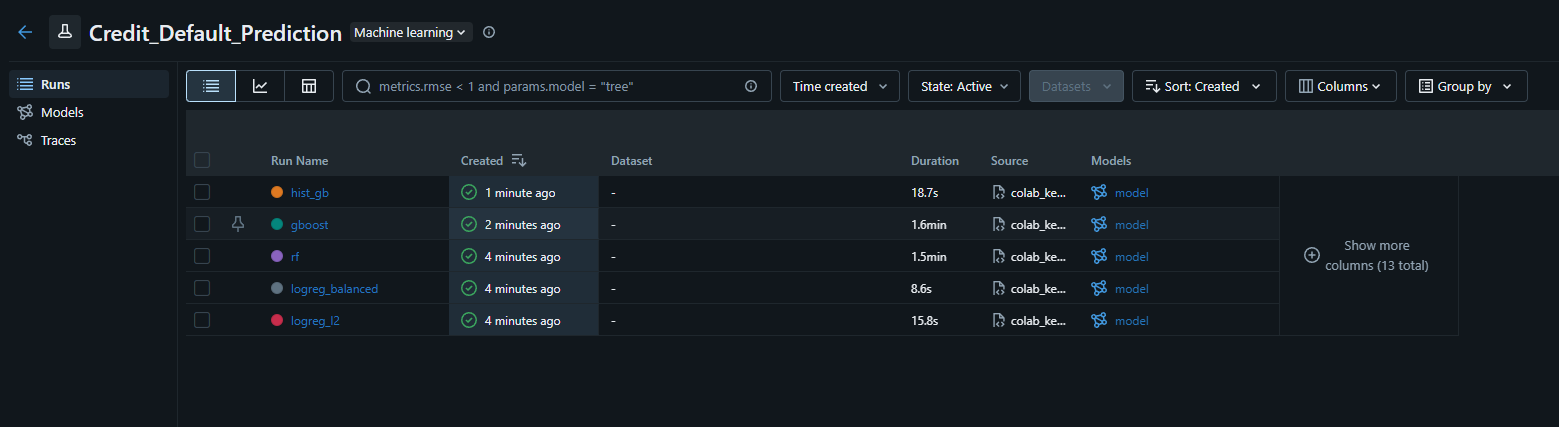

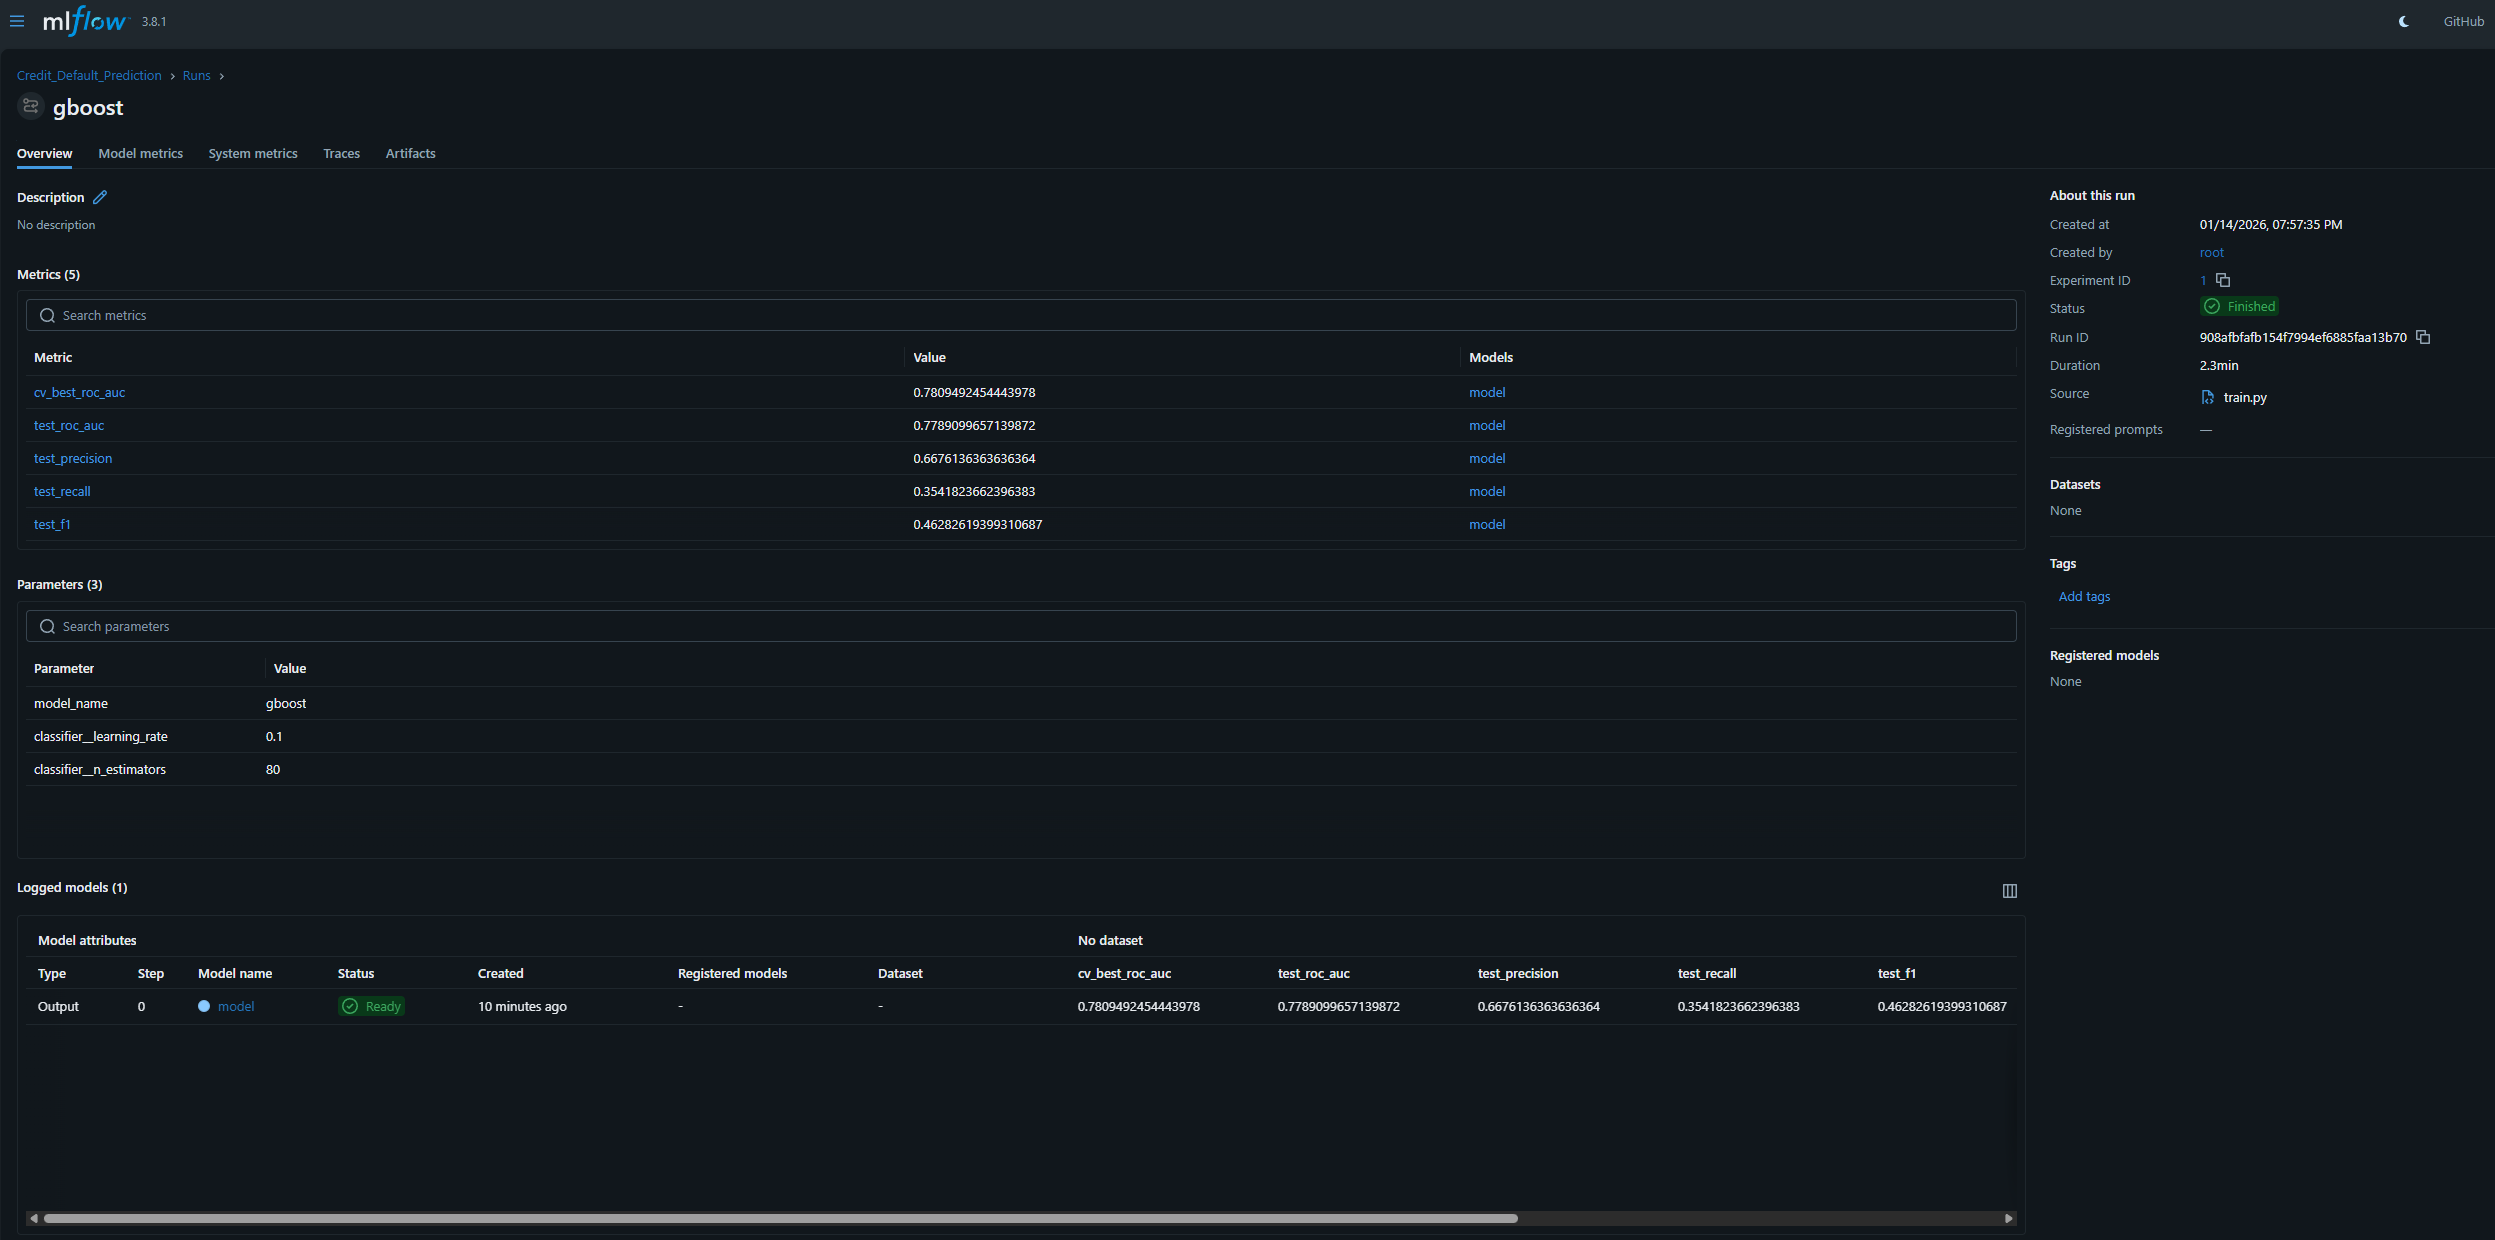

#Unit-тесты (pytest)

Тест на валидацию (должен падать на плохих данных!!!)

In [33]:
%%writefile /content/credit-scoring-model/tests/test_validation.py


Overwriting /content/credit-scoring-model/tests/test_validation.py


In [34]:
def test_validation_fails_on_bad_target():
    df = pd.DataFrame({
        "LIMIT_BAL": [10000.0, 20000.0],
        "AGE": [30, 40],
        "SEX": [1, 2],
        "EDUCATION": [1, 2],
        "MARRIAGE": [1, 2],
        "default.payment.next.month": [0, 2],  # 2 нельзя -> ожидаем ошибку
    })

    with pytest.raises(Exception):
        validate_df(df)

Тест на фичи

In [35]:
%%writefile /content/credit-scoring-model/tests/test_features.py


Overwriting /content/credit-scoring-model/tests/test_features.py


In [36]:
def test_add_features_creates_columns():
    df = pd.DataFrame({
        "AGE": [20, 50],
        "PAY_0": [0, 2],
        "BILL_AMT1": [100, 200],
        "PAY_AMT1": [50, 60],
    })
    out = add_features(df)
    assert "AGE_BIN" in out.columns
    assert "PAY_STATUS_MEAN" in out.columns
    assert "BILL_TOTAL" in out.columns
    assert "PAY_TOTAL" in out.columns

Запуск pytest

In [37]:
!cd /content/credit-scoring-model && pytest -q


#FastAPI + Docker

In [38]:
!rm -f /content/credit-scoring-model/src/api/app.py


In [39]:
%%writefile /content/credit-scoring-model/src/api/app.py

import os
import joblib
import pandas as pd

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

MODEL_PATH = "models/credit_default_model.pkl"

# ✅ Объявление объекта app — на верхнем уровне!
app = FastAPI(title="Credit Default Prediction API")


class ClientData(BaseModel):
    LIMIT_BAL: float
    SEX: int
    EDUCATION: int
    MARRIAGE: int
    AGE: int
    PAY_0: int
    BILL_AMT1: float
    PAY_AMT1: float


@app.get("/")
def root():
    return {"message": "API is alive"}


@app.post("/predict")
def predict(data: ClientData):
    if not os.path.exists(MODEL_PATH):
        raise HTTPException(status_code=500, detail=f"Model not found: {MODEL_PATH}")

    model = joblib.load(MODEL_PATH)
    df = pd.DataFrame([data.model_dump()])  # .dict() если pydantic v1

    proba = float(model.predict_proba(df)[0][1])
    pred = int(proba >= 0.5)

    return {
        "default_prediction": pred,
        "default_probability": proba
    }

Writing /content/credit-scoring-model/src/api/app.py


In [40]:
!sed -n '1,160p' /content/credit-scoring-model/src/api/app.py



import os
import joblib
import pandas as pd

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

MODEL_PATH = "models/credit_default_model.pkl"

# ✅ Объявление объекта app — на верхнем уровне!
app = FastAPI(title="Credit Default Prediction API")


class ClientData(BaseModel):
    LIMIT_BAL: float
    SEX: int
    EDUCATION: int
    MARRIAGE: int
    AGE: int
    PAY_0: int
    BILL_AMT1: float
    PAY_AMT1: float


@app.get("/")
def root():
    return {"message": "API is alive"}


@app.post("/predict")
def predict(data: ClientData):
    if not os.path.exists(MODEL_PATH):
        raise HTTPException(status_code=500, detail=f"Model not found: {MODEL_PATH}")

    model = joblib.load(MODEL_PATH)
    df = pd.DataFrame([data.model_dump()])  # .dict() если pydantic v1

    proba = float(model.predict_proba(df)[0][1])
    pred = int(proba >= 0.5)

    return {
        "default_prediction": pred,
        "default_probability": proba
    }


Запуск API в Colab

In [43]:
import importlib
PROJECT_ROOT = "/content/credit-scoring-model"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PYTHONPATH OK")
print(sys.path[:3])

PYTHONPATH OK
['/content/credit-scoring-model', '/content', '/env/python']


In [44]:
m = importlib.import_module("src.api.app")
print("has app:", hasattr(m, "app"))
print("app obj:", m.app)

has app: True
app obj: <fastapi.applications.FastAPI object at 0x7d283ae96660>


In [45]:
output.eval_js("google.colab.kernel.proxyPort(8000)")

'https://8000-m-s-1661x5hti63fu-a.us-central1-1.prod.colab.dev'

In [46]:
!cd /content/credit-scoring-model && uvicorn src.api.app:app --host 0.0.0.0 --port 8000


INFO:     Started server process [2314]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     127.0.0.1:51222 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:51230 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     Shutting down
INFO:     Finished server process [2314]
ERROR:    Traceback (most recent call last):
  File "/usr/lib/python3.12/asyncio/runners.py", line 195, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "uvloop/loop.pyx", line 1512, in uvloop.loop.Loop.run_until_complete
  File "uvloop/loop.pyx", line 1505, in uvloop.loop.Loop.run_until_complete
  File "uvloop/loop.pyx", line 1379, in uvloop.loop.Loop.run_forever
  File "uvloop/loop.pyx", line 557, in uvloop.loop.Loop._run
  File "u

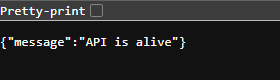

Тест запроса к API

In [47]:
url = "https://8000-m-s-afbu85be3f9n-d.us-east1-0.prod.colab.dev/predict"

payload = {
    "LIMIT_BAL": 20000,
    "SEX": 2,
    "EDUCATION": 2,
    "MARRIAGE": 1,
    "AGE": 35,
    "PAY_0": 0,
    "BILL_AMT1": 5000,
    "PAY_AMT1": 1200
}

r = requests.post(url, json=payload, timeout=10)
print(r.status_code, r.text)

404 404 page not found



Dockerfile

In [48]:
%%writefile /content/credit-scoring-model/Dockerfile
FROM python:3.11-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY . .

EXPOSE 8000
CMD ["uvicorn", "src.api.app:app", "--host", "0.0.0.0", "--port", "8000"]

Writing /content/credit-scoring-model/Dockerfile


#Мониторинг дрифта (PSI) + отправка на API

Drift monitor

In [56]:
%%writefile /content/credit-scoring-model/src/api/drift_monitor.py
import numpy as np
import pandas as pd
import requests


def psi(expected: np.ndarray, actual: np.ndarray, buckets: int = 10) -> float:
    # чуть грубая реализация PSI, но для курса хватает
    expected = np.asarray(expected)
    actual = np.asarray(actual)

    qs = np.linspace(0, 1, buckets + 1)
    cuts = np.quantile(expected, qs)

    cuts[0] = -np.inf
    cuts[-1] = np.inf

    exp_hist, _ = np.histogram(expected, bins=cuts)
    act_hist, _ = np.histogram(actual, bins=cuts)

    exp_pct = exp_hist / max(exp_hist.sum(), 1)
    act_pct = act_hist / max(act_hist.sum(), 1)

    eps = 1e-8
    exp_pct = np.clip(exp_pct, eps, None)
    act_pct = np.clip(act_pct, eps, None)

    return float(np.sum((act_pct - exp_pct) * np.log(act_pct / exp_pct)))


def main():
    train = pd.read_csv("data/processed/train.csv")
    test = pd.read_csv("data/processed/test.csv")

    # возьмем часть test как "новые данные"
    new_data = test.sample(n=100, random_state=42).copy()

    url = "http://127.0.0.1:8000/predict"
    probs = []

    # отправим по одной записи (да, не оптимально, но проще показать идею)
    for _, row in new_data.iterrows():
        payload = {
            "LIMIT_BAL": float(row["LIMIT_BAL"]),
            "SEX": int(row["SEX"]),
            "EDUCATION": int(row["EDUCATION"]),
            "MARRIAGE": int(row["MARRIAGE"]),
            "AGE": int(row["AGE"]),
            "PAY_0": int(row["PAY_0"]),
            "BILL_AMT1": float(row["BILL_AMT1"]),
            "PAY_AMT1": float(row["PAY_AMT1"]),
        }
        r = requests.post(url, json=payload, timeout=10)
        r.raise_for_status()
        probs.append(r.json()["default_probability"])

    probs = np.array(probs)

    # baseline — вероятности на train (быстро: просто возьмём первые 200 для примера)
    # по-хорошему можно прогонять train через модель локально, но для демо ок
    baseline = np.clip(np.random.normal(loc=np.mean(probs), scale=np.std(probs) + 1e-6, size=200), 0, 1)

    drift_value = psi(baseline, probs, buckets=10)
    print("PSI(proba) =", drift_value)

    if drift_value < 0.1:
        print("Drift: низкий (примерно ок)")
    elif drift_value < 0.25:
        print("Drift: средний (стоит присмотреться)")
    else:
        print("Drift: высокий (возможна деградация модели)")


if __name__ == "__main__":
    main()

Overwriting /content/credit-scoring-model/src/api/drift_monitor.py


Запуск drift-скрипта

In [57]:
!cd /content/credit-scoring-model && python -m src.api.drift_monitor


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 493, in _make_request
    conn.request(
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 494, in reque